## Thanks to [Hazami  Louay](https://www.kaggle.com/arsenalist/bitcoin-prices-prediction) for the great notebook! I just added more classifiers and the output from all classifiers stacked into Extreme Gradient Boosting

## I will use Adaptive Boosting, Bagging, Extra Trees, Gradient Boosting and Random Forest for the base models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import time
from datetime import datetime
from datetime import timedelta
from sklearn import cross_validation
from sklearn.ensemble import *
sns.set()

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('../input/all-crypto-currencies/crypto-markets.csv', parse_dates=['date'], index_col='date')
df = df[df['symbol']=='BTC']
df.drop(['volume','symbol','name','ranknow','market'],axis=1,inplace=True)
df.head()

,open,high,low,close
date,,,,
2013-04-28,135.30,135.98,132.10,134.21
2013-04-29,134.44,147.49,134.00,144.54
2013-04-30,144.00,146.93,134.05,139.00
2013-05-01,139.00,139.89,107.72,116.99
2013-05-02,116.38,125.60,92.28,105.21


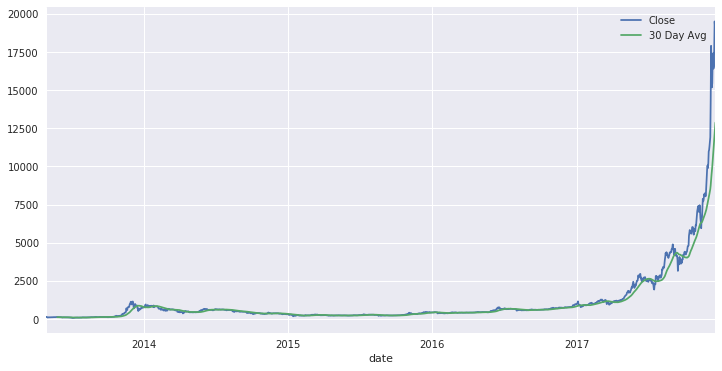

In [3]:
df['close'].plot(figsize=(12,6),label='Close')
df['close'].rolling(window=30).mean().plot(label='30 Day Avg')
plt.legend()

For me, I prefer to use MinMaxScaler (0, 1) from sklearn

I set the period is 30, that is mean, today value is going to look 30 days ahead, you can change into any value. but do not too low or else the fitting will become saturated.

In [4]:
period = 30
minmax = MinMaxScaler().fit(df.iloc[:, 3].values.reshape((-1,1)))
close_normalize = minmax.transform(df.iloc[:, 3].values.reshape((-1,1)))
normalized = pd.DataFrame(close_normalize)
normalized['Price_After_period']=normalized[0].shift(-period)
normalized.dropna(inplace=True)
X=normalized.drop('Price_After_period',axis=1)
print(normalized.head())
y=normalized['Price_After_period']
print(X.head())
y.head()

          0  Price_After_period
0  0.003386            0.003118
1  0.003917            0.003287
2  0.003632            0.003107
3  0.002499            0.003118
4  0.001893            0.003133
          0
0  0.003386
1  0.003917
2  0.003632
3  0.002499
4  0.001893


0    0.003118
1    0.003287
2    0.003107
3    0.003118
4    0.003133
Name: Price_After_period, dtype: float64

In [5]:
train_X,test_X,train_Y,test_Y=cross_validation.train_test_split(X,
                                                                y,
                                                                test_size=0.2,random_state=101)

In [6]:
from sklearn.ensemble import *
ada = AdaBoostRegressor(n_estimators=500, learning_rate=0.1)
bagging = BaggingRegressor(n_estimators=500)
et = ExtraTreesRegressor(n_estimators=500)
gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.1)
rf = RandomForestRegressor(n_estimators=500,random_state=101)

In [7]:
ada.fit(train_X, train_Y)
bagging.fit(train_X, train_Y)
et.fit(train_X, train_Y)
gb.fit(train_X, train_Y)
rf.fit(train_X, train_Y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=101, verbose=0, warm_start=False)

In [8]:
accuracy=ada.score(test_X, test_Y)
accuracy=accuracy*100
accuracy = float("{0:.4f}".format(accuracy))
print('Adaptive Accuracy is:',accuracy,'%')

Adaptive Accuracy is: 91.0713 %


In [9]:
accuracy=bagging.score(test_X, test_Y)
accuracy=accuracy*100
accuracy = float("{0:.4f}".format(accuracy))
print('Bagging Accuracy is:',accuracy,'%')

Bagging Accuracy is: 90.1955 %


In [10]:
accuracy=et.score(test_X, test_Y)
accuracy=accuracy*100
accuracy = float("{0:.4f}".format(accuracy))
print('Extra Trees Accuracy is:',accuracy,'%')

Extra Trees Accuracy is: 89.3249 %


In [11]:
accuracy=gb.score(test_X, test_Y)
accuracy=accuracy*100
accuracy = float("{0:.4f}".format(accuracy))
print('Gradient Boosting Accuracy is:',accuracy,'%')

Gradient Boosting Accuracy is: 89.4583 %


In [12]:
accuracy=rf.score(test_X, test_Y)
accuracy=accuracy*100
accuracy = float("{0:.4f}".format(accuracy))
print('Random Forest Accuracy is:',accuracy,'%')

Random Forest Accuracy is: 90.2607 %


Now, which model predict almost near to our test value?

# Pearson please!

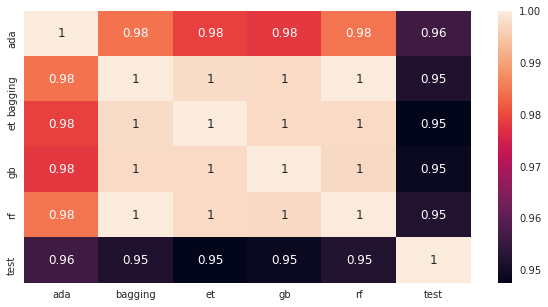

In [13]:
ada_out = ada.predict(test_X)
bagging_out = bagging.predict(test_X)
et_out = et.predict(test_X)
gb_out = gb.predict(test_X)
rf_out = rf.predict(test_X)
stack_predict = np.vstack([ada_out,bagging_out,et_out,gb_out,rf_out,test_Y]).T
corr_df = pd.DataFrame(stack_predict, columns=['ada','bagging','et','gb','rf','test'])
plt.figure(figsize=(10,5))
sns.heatmap(corr_df.corr(), annot=True)
plt.show()

Seaborn round up the numbers, plus the value is still normalized

In [14]:
corr_df.head()

,ada,bagging,et,gb,rf,test
0,0.019654,0.037666,0.034039,0.034000,0.037502,0.029012
1,0.019461,0.028985,0.029718,0.026471,0.029008,0.027728
2,0.019461,0.028023,0.028283,0.028248,0.027998,0.026732
3,0.019452,0.009870,0.008767,0.010392,0.009865,0.008975
4,0.019452,0.020154,0.019696,0.020466,0.020202,0.015803


In [15]:
corr_df.ada = minmax.inverse_transform(corr_df.ada.values.reshape((-1,1))).flatten()
corr_df.bagging = minmax.inverse_transform(corr_df.bagging.values.reshape((-1,1))).flatten()
corr_df.et = minmax.inverse_transform(corr_df.et.values.reshape((-1,1))).flatten()
corr_df.gb = minmax.inverse_transform(corr_df.gb.values.reshape((-1,1))).flatten()
corr_df.rf = minmax.inverse_transform(corr_df.rf.values.reshape((-1,1))).flatten()
corr_df.test = minmax.inverse_transform(corr_df.test.values.reshape((-1,1))).flatten()

In [16]:
corr_df.head()

,ada,bagging,et,gb,rf,test
0,450.280527,800.246949,729.77210,729.006170,797.049749,632.10
1,446.532909,631.571725,645.81720,582.731579,632.033173,607.15
2,446.532909,612.892828,617.94360,617.253599,612.397676,587.80
3,446.357851,260.197647,238.76711,270.339213,260.105674,242.80
4,446.357851,459.998532,451.10000,466.065859,460.941716,375.47


## Now we able to see the huge difference!

In [17]:
import xgboost as xgb

params_xgd = {
    'max_depth': 7,
    'objective': 'reg:linear',
    'learning_rate': 0.033,
    'n_estimators': 10000
    }
clf = xgb.XGBRegressor(**params_xgd)
stack_train = np.vstack([ada.predict(train_X),
                           bagging.predict(train_X),
                           et.predict(train_X),
                           gb.predict(train_X),
                          rf.predict(train_X)]).T

stack_test = np.vstack([ada.predict(test_X),
                           bagging.predict(test_X),
                           et.predict(test_X),
                           gb.predict(test_X),
                          rf.predict(test_X)]).T

clf.fit(stack_train, train_Y, eval_set=[(stack_test, test_Y)], 
        eval_metric='rmse', early_stopping_rounds=20, verbose=True)

[0]	validation_0-rmse:0.448557
Will train until validation_0-rmse hasn't improved in 20 rounds.
[1]	validation_0-rmse:0.433984
[2]	validation_0-rmse:0.419885
[3]	validation_0-rmse:0.406246
[4]	validation_0-rmse:0.393072
[5]	validation_0-rmse:0.380311
[6]	validation_0-rmse:0.367986
[7]	validation_0-rmse:0.356045
[8]	validation_0-rmse:0.344519
[9]	validation_0-rmse:0.333368
[10]	validation_0-rmse:0.322582
[11]	validation_0-rmse:0.31217
[12]	validation_0-rmse:0.302104
[13]	validation_0-rmse:0.292369
[14]	validation_0-rmse:0.282961
[15]	validation_0-rmse:0.273851
[16]	validation_0-rmse:0.265058
[17]	validation_0-rmse:0.256567
[18]	validation_0-rmse:0.248357
[19]	validation_0-rmse:0.240434
[20]	validation_0-rmse:0.232769
[21]	validation_0-rmse:0.225331
[22]	validation_0-rmse:0.218178
[23]	validation_0-rmse:0.211272
[24]	validation_0-rmse:0.204598
[25]	validation_0-rmse:0.198127
[26]	validation_0-rmse:0.191874
[27]	validation_0-rmse:0.185857
[28]	validation_0-rmse:0.180042
[29]	validation_0-

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.033, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=10000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

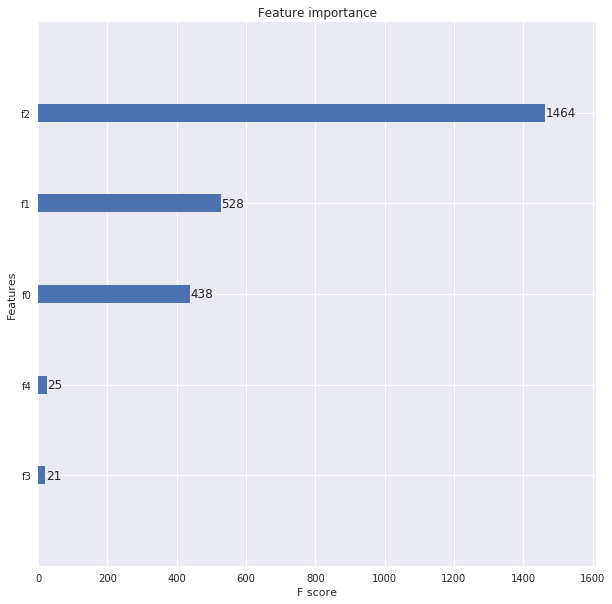

In [18]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(clf, ax=ax)
plt.show()

f2 = extra trees, wew!

## Now it is time to predict, we will predict 10 days in the future, what happen to Bitcoin

In [19]:
out_ada=X[0].tolist() + ada.predict(X[-period-10:]).tolist()
out_bagging=X[0].tolist() + bagging.predict(X[-period-10:]).tolist()
out_et=X[0].tolist() + et.predict(X[-period-10:]).tolist()
out_gb=X[0].tolist() + gb.predict(X[-period-10:]).tolist()
out_rf=X[0].tolist() + rf.predict(X[-period-10:]).tolist()

In [20]:
out_xgb=X[0].tolist()+clf.predict(np.vstack([ada.predict(X[-period-10:]),
                           bagging.predict(X[-period-10:]),
                           et.predict(X[-period-10:]),
                           gb.predict(X[-period-10:]),
                          rf.predict(X[-period-10:])]).T).tolist()

In [21]:
last_date=pd.to_datetime(df.iloc[-1].name)
print(last_date)
modified_date = last_date + timedelta(days=1)
date=pd.date_range(modified_date,periods=period,freq='D')

2017-12-18 00:00:00


In [22]:
out_ada = minmax.inverse_transform(np.array(out_ada).reshape((-1,1))).flatten()
out_bagging = minmax.inverse_transform(np.array(out_bagging).reshape((-1,1))).flatten()
out_et = minmax.inverse_transform(np.array(out_et).reshape((-1,1))).flatten()
out_gb = minmax.inverse_transform(np.array(out_gb).reshape((-1,1))).flatten()
out_rf = minmax.inverse_transform(np.array(out_rf).reshape((-1,1))).flatten()
out_xgb = minmax.inverse_transform(np.array(out_xgb).reshape((-1,1))).flatten()

In [23]:
date_ori=pd.to_datetime(df.index.date[:-period+10]).strftime(date_format='%Y-%m-%d').tolist()+pd.Series(date).dt.strftime(date_format='%Y-%m-%d').tolist()

In [24]:
len(date_ori)

1706

In [25]:
len(out_ada)

1706

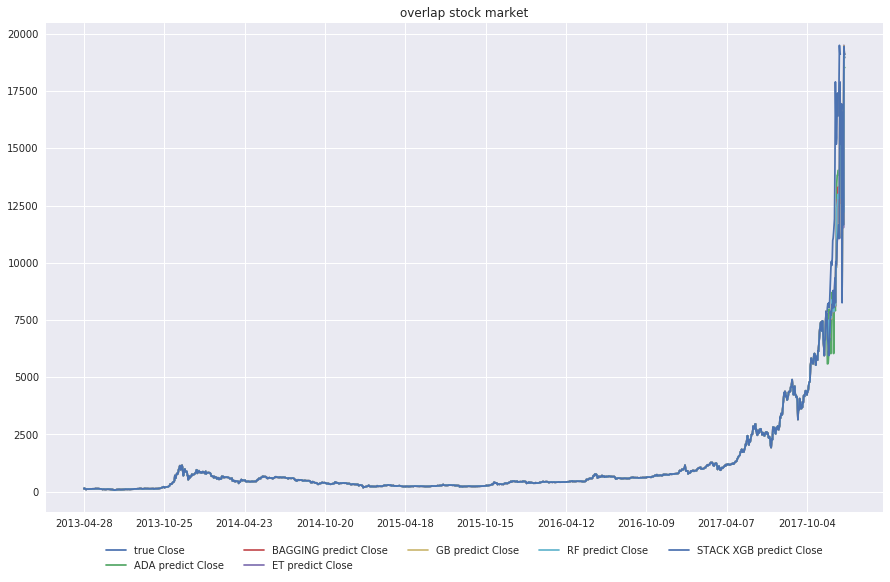

In [26]:
fig = plt.figure(figsize = (15,10))
ax = plt.subplot(111)
x_range = np.arange(df.shape[0])
x_range_future = np.arange(len(out_ada))
ax.plot(x_range, df.close, label = 'true Close')
ax.plot(x_range_future, out_ada, label = 'ADA predict Close')
ax.plot(x_range_future, out_bagging, label = 'BAGGING predict Close')
ax.plot(x_range_future, out_et, label = 'ET predict Close')
ax.plot(x_range_future, out_gb, label = 'GB predict Close')
ax.plot(x_range_future, out_rf, label = 'RF predict Close')
ax.plot(x_range_future, out_xgb, label = 'STACK XGB predict Close')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc = 'upper center', bbox_to_anchor= (0.5, -0.05), fancybox = True, shadow = True, ncol = 5)
plt.title('overlap stock market')
plt.xticks(x_range_future[::180], date_ori[::180])
plt.show()

Wait..

In [27]:
from PIL import Image
bitcoin_im = Image.open('../input/bitcoinpic/Bitcoin-Logo-640x480.png')

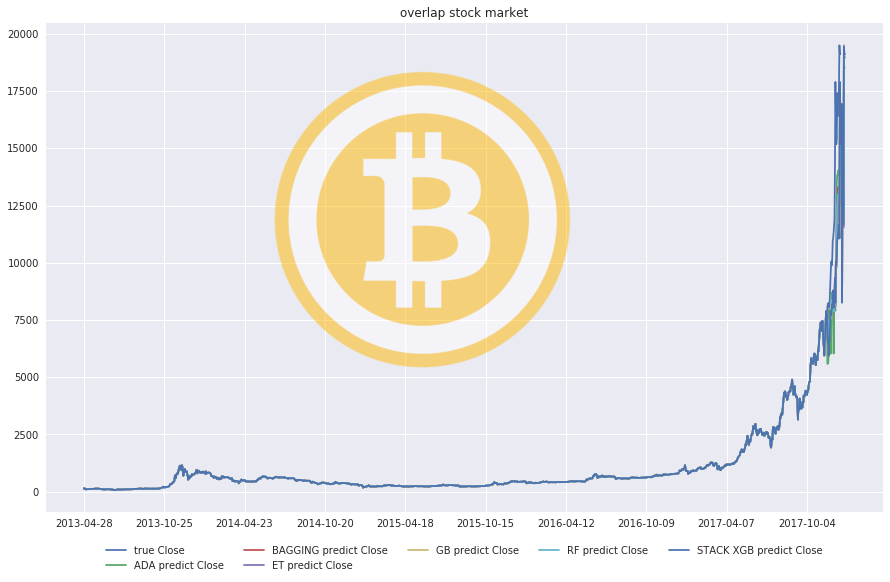

In [28]:
fig = plt.figure(figsize = (15,10))
ax = plt.subplot(111)
x_range = np.arange(df.shape[0])
x_range_future = np.arange(len(out_ada))
ax.plot(x_range, df.close, label = 'true Close')
ax.plot(x_range_future, out_ada, label = 'ADA predict Close')
ax.plot(x_range_future, out_bagging, label = 'BAGGING predict Close')
ax.plot(x_range_future, out_et, label = 'ET predict Close')
ax.plot(x_range_future, out_gb, label = 'GB predict Close')
ax.plot(x_range_future, out_rf, label = 'RF predict Close')
ax.plot(x_range_future, out_xgb, label = 'STACK XGB predict Close')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc = 'upper center', bbox_to_anchor= (0.5, -0.05), fancybox = True, shadow = True, ncol = 5)
plt.title('overlap stock market')
plt.xticks(x_range_future[::180], date_ori[::180])
fig.figimage(bitcoin_im, 100, 120, zorder=3,alpha=.5)
plt.show()

# Way more cooler, Biatch!

why font for single hash not very big.

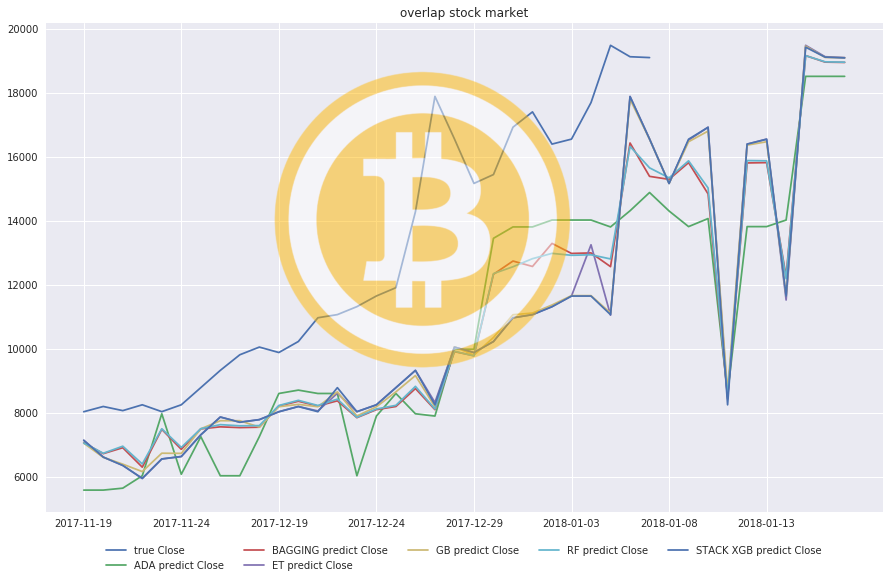

In [29]:
fig = plt.figure(figsize = (15,10))
ax = plt.subplot(111)
x_range = np.arange(df.shape[0])
x_range_future = np.arange(len(out_ada))
ax.plot(x_range[-30:], df.close[-30:], label = 'true Close')
ax.plot(x_range_future[-40:], out_ada[-40:], label = 'ADA predict Close')
ax.plot(x_range_future[-40:], out_bagging[-40:], label = 'BAGGING predict Close')
ax.plot(x_range_future[-40:], out_et[-40:], label = 'ET predict Close')
ax.plot(x_range_future[-40:], out_gb[-40:], label = 'GB predict Close')
ax.plot(x_range_future[-40:], out_rf[-40:], label = 'RF predict Close')
ax.plot(x_range_future[-40:], out_xgb[-40:], label = 'STACK XGB predict Close')
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])
ax.legend(loc = 'upper center', bbox_to_anchor= (0.5, -0.05), fancybox = True, shadow = True, ncol = 5)
plt.title('overlap stock market')
plt.xticks(x_range_future[-40:][::5], date_ori[-40:][::5])
fig.figimage(bitcoin_im, 100, 120, zorder=3,alpha=.5)
plt.show()